# Density Profiles at Given Times

This notebook plots a number of density profiles at given times and plots an underlying signal. Both in $\rho$ and in R.

In [14]:
%matplotlib notebook

import matplotlib
# matplotlib.use("Agg")
from IPython.core.display import display, HTML
from ipfnpytools.getsig import getsig
import ipfnpytools.aug_read as aug_read
from ipfnpytools.closest import closest
from __future__ import print_function
from ipfnpytools.plot import plots
from warnings import warn
import numpy as np
from ipfnpytools.save_figure import save_figure
from ipfnpytools import rps_dump
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets
from scipy.ndimage import uniform_filter1d
from matplotlib.lines import Line2D
from ipfnpytools.ddremoveELMData import ddremoveELMData 

#https://stackoverflow.com/questions/27427618/how-can-i-simply-calculate-the-rolling-moving-variance-of-a-time-series-in-pytho/47878011
def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def rolling_variance(x, N):
    """Computes the rolling variance along the last axis"""
    return np.var(rolling_window(x, N), axis=-1)

# https://github.com/matplotlib/matplotlib/issues/4556
def update_errorbar(errobj, x, y, xerr=None, yerr=None, lowxerr=None, upxerr=None, lowyerr=None, upyerr=None):
    ln, caps, bars = errobj


    if len(bars) == 2:
        assert (xerr is not None and yerr is not None) or \
               (lowxerr is not None and upxerr is not None and lowyerr is not None and upyerr is not None),\
               "Your errorbar object has 2 dimension of error bars defined. You must provide xerr and yerr."
        barsx, barsy = bars  # bars always exist (?)
        try:  # caps are optional
            errx_top, errx_bot, erry_top, erry_bot = caps
        except ValueError:  # in case there is no caps
            pass

    elif len(bars) == 1:
        assert (xerr is     None and yerr is not None) or\
               (xerr is not None and yerr is     None) or\
               (lowxerr is None and upxerr is None and lowyerr is not None and upyerr is not None) or\
               (lowxerr is not None and upxerr is not None and lowyerr is None and upyerr is None),  \
               "Your errorbar object has 1 dimension of error bars defined. You must provide xerr or yerr."

        if (xerr is not None) or (lowxerr is not None and upxerr is not None):
            barsx, = bars  # bars always exist (?)
            try:
                errx_top, errx_bot = caps
            except ValueError:  # in case there is no caps
                pass
        else:
            barsy, = bars  # bars always exist (?)
            try:
                erry_top, erry_bot = caps
            except ValueError:  # in case there is no caps
                pass

    ln.set_data(x,y)
    
    if lowxerr is None: lowxerr = xerr
    if upxerr is None: upxerr = xerr
    if lowyerr is None: lowyerr = yerr
    if upyerr is None: upyerr = yerr

    try:
        errx_top.set_xdata(x + upxerr)
        errx_bot.set_xdata(x - lowxerr)
        errx_top.set_ydata(y)
        errx_bot.set_ydata(y)
    except NameError:
        pass
    try:
        barsx.set_segments([np.array([[xt, y], [xb, y]]) for xt, xb, y in zip(x + upxerr, x - lowxerr, y)])
    except NameError:
        pass

    try:
        erry_top.set_xdata(x)
        erry_bot.set_xdata(x)
        erry_top.set_ydata(y + upyerr)
        erry_bot.set_ydata(y - lowyerr)
    except NameError:
        pass
    try:
        barsy.set_segments([np.array([[x, yt], [x, yb]]) for x, yt, yb in zip(x, y + upyerr, y - lowyerr)])
    except NameError:
        pass

## Parameters

Change these parameters to fit your needs

In [2]:
# Shot number
shot = 37750

# Choose edition for reflectometry (0 for most recent)
edition = 0

# Choose profile source between 'afs' and 'dump'
source = 'afs'

# Path to dump file 
path = "/afs/ipp-garching.mpg.de/home/d/danielhfc/lab_rot/phd_part8_faitch_initializations/xhfs_2sep-0m050_xlfs_2m230.37765" 

# If chosen 'dump', state the relative path
support_signal = ('FPG', 'delRoben')

# Choose edition for the supporting signal (0 for most recent)
support_signal_edition = 0

# Magnetic equillibrium
equillibrium = "EQH"

# Number of density profiles to show in the plots
number_of_profiles = 3

# Size of window to average profiles [ms]
time_window = 1000

# Show error bars corresponding to the standard deviation of the average profile
show_std = True

# Show HFS and LFS rho profiles in the same window
show_same = False

# Show wall
show_wall = True

# Time to reject before each ELM peak [ms]
preft = 1

# Time to reject after each ELM peak [ms]
suft = 2

# Select diagnostic for testing ELM rejection ("Shotfile", "Signal")
diag = ("MAC", "Ipolsoli")

## Load support signal from AFS

/afs/ipp/aug/ads-diags/common/python/lib/dd.py:118: RuntimeWarning: Warning by DDcsgnl (8.1): no calibration of data
  warnings.warn(err_txt, RuntimeWarning)


<IPython.core.display.Javascript object>


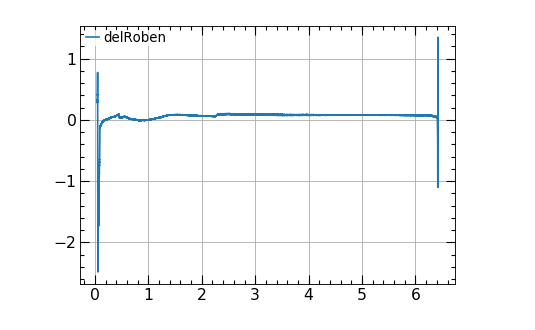

(<Figure size 535.433x330.916 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b9c5c79f3d0>)

In [3]:
signal = getsig(shot, support_signal[0], support_signal[1], edition=support_signal_edition)
plots(signal.time, signal.data, labels=signal.name)

## Remove ELMs

Using the _ELM_ shotfile we mask the ELMs. To better filter out the ELMs we need to specify a rejection window arround the ELM peak. For example, we can reject one millisecond before the peak `preft = 1` and two milliseconds after the peak `suft=2`. To verify that the ELM rejection routine is working properly, we can test it on an arbitrary diagnostic, e.g., `MAC/Ipolsoli` or `POT/EMLa-Han`

**Change the parameters in the next cell accordingly.**

In [4]:
# Get ELM mask from the ELM shotfile
test_signal = getsig(shot, diag[0], diag[1])
elmmsk = ddremoveELMData(shot, test_signal.time, preft=preft*1e-3, suft=suft*1e-3)

<IPython.core.display.Javascript object>


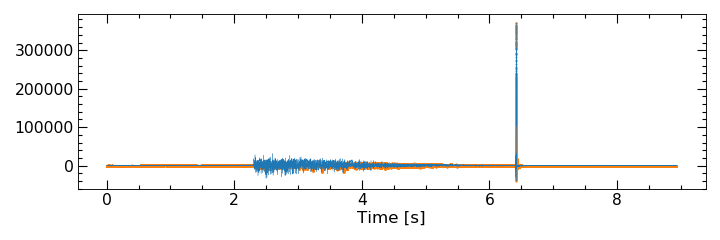

In [5]:
plt.figure(figsize=(9, 3))
plt.plot(test_signal.time, test_signal.data, lw=0.3)
plt.scatter(test_signal.time[elmmsk], test_signal.data[elmmsk], color='C1', marker='o', s=1)
plt.grid()
plt.xlabel("Time [s]")
plt.tight_layout()
# plt.xlim(2.2, 6.3)
# plt.ylim(-4e4, 4e4)

## Get density profile data

In [6]:
if source == 'dump':
    # Instantiate the ShotFile class with the path to the dump file
    shotfile = rps_dump.ShotFile(path)

    ne_lfs = shotfile("neb_LFS")
    ne_hfs = shotfile("neb_HFS")

    # Time array is equal for LFS and HFS
    time = ne_lfs.time

    # Low-field side
    lfs_signal = ne_lfs.data
    lfs_area = ne_lfs.area.data

    # High-field side
    hfs_signal = ne_hfs.data
    hfs_area = ne_hfs.area.data
    
elif source == 'afs':

    data = aug_read.many_signals(
        diagnostics=(["RPS"] * 2),
        names=['neb_LFS', 'neb_HFS'],
        shots=shot,
        editions=edition
    )

    # Time array is equal for LFS and HFS
    time = data.times[0]

    # Low-field side
    lfs_signal = data.signals[0]
    lfs_area = data.areas[0]

    # High-field side
    hfs_signal = data.signals[1]
    hfs_area = data.areas[1]


print("time:", time.shape)
print("lfs_signal:", lfs_signal.shape)
print("lfs_area:", lfs_area.shape)
print("hfs_signal:", hfs_signal.shape)
print("hfs_area:", hfs_area.shape)

/afs/ipp/aug/ads-diags/common/python/lib/dd.py:118: RuntimeWarning: Warning by DDcsgrp (8.1): No PARAM_SET found
  warnings.warn(err_txt, RuntimeWarning)


time: (37323,)
lfs_signal: (37323, 151)
lfs_area: (37323, 151)
hfs_signal: (37323, 151)
hfs_area: (37323, 151)


## Remove ELMs from density profiles

In [7]:
mask = ddremoveELMData(shot, time, preft=preft*1e-3, suft=suft*1e-3)

In [31]:
time_masked = time[mask]

# Determine which time indexes draw profiles
draw = np.linspace(0, len(time_masked), number_of_profiles + 2, dtype=np.int)
draw = draw[1:-1]

# Handling average profiles
time_limits = np.array([-1.0, 1.0])*time_window/2000
time_limits = np.array([time_limits+time[d] for d in draw])

indexes = closest(time, time_limits.flatten()).reshape((number_of_profiles, 2))
N = indexes[0, 1] - indexes[0, 0]
print("Averaging %d profiles on a %.3lf ms window." % (N, time_window))

# Remove NaN's
lfs_area = np.nan_to_num(lfs_area)
hfs_area = np.nan_to_num(hfs_area)

# # Apply the ELM removal mask
lfs_area_masked = lfs_area[mask]
hfs_area_masked = hfs_area[mask]

lfs_average = pd.DataFrame(lfs_area_masked).rolling(window=N).mean().values
hfs_average = pd.DataFrame(hfs_area_masked).rolling(window=N).mean().values

lfs_average = np.nan_to_num(lfs_average)
hfs_average = np.nan_to_num(hfs_average)

lfs_std = pd.DataFrame(lfs_area_masked).rolling(window=N).std().values
hfs_std = pd.DataFrame(hfs_area_masked).rolling(window=N).std().values

lfs_std = np.nan_to_num(lfs_std)
hfs_std = np.nan_to_num(hfs_std)

# lfs_average = uniform_filter1d(lfs_area_masked, N, axis=0)
# print("Computed LFS average")
# hfs_average = uniform_filter1d(hfs_area_masked, N, axis=0)
# print("Computed HFS average")

# lfs_std = np.sqrt(rolling_variance(lfs_area_masked.T, N)).T[:,0:lfs_average.shape[1]]
# print("Computed LFS variance")
# hfs_std = np.sqrt(rolling_variance(hfs_area_masked.T, N)).T[:,0:hfs_average.shape[1]]
# print("Computed HFS variance")

Averaging 5714 profiles on a 1000.000 ms window.


<IPython.core.display.Javascript object>


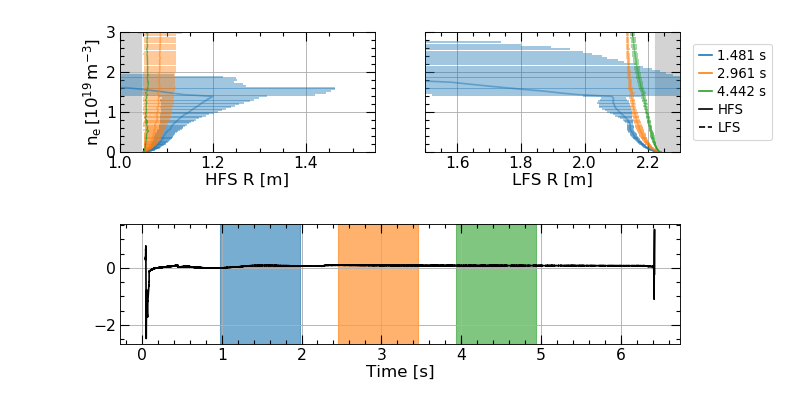

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTQuNDQyMTA3Njc3NDU5NzE3LCBkZXNjcmlwdGlvbj11J1RpbWUgW3NdJywgbWF4PTYuNTMxNDMyNjI4NjMxNTkyLCBtaW7igKY=


In [32]:
fig1 = plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.2, hspace=0.6)

# Supporting plot with colored lines
ax1 = plt.subplot(212)
stamp1 = []
ax1.plot(signal.time, signal.data, color='k')
for a, b in indexes:
    color = next(ax1._get_lines.prop_cycler)['color']
    l = ax1.axvspan(time[a], time[b], color=color, alpha=0.6)
#     l = ax1.axvline(time[i], color=color)
    stamp1.append(l)


ax2 = plt.subplot(221)

ax3 = plt.subplot(222, sharey=ax2)
ax3.tick_params(labelleft=False)

# Interpolating radial coordinates
radius = np.linspace(1.0, 2.3, 1000)


hfs = []
lfs = []
legend_lines = []

for i in draw:
    color = next(ax2._get_lines.prop_cycler)['color']
    legend_lines.append(Line2D([0], [0], color=color, linewidth=1.5, linestyle='-'))
    
    if show_std:
        l = ax2.errorbar(hfs_average[i], hfs_signal[i]*1e-19, xerr=hfs_std[i], 
                         alpha=0.5, color=color, label='%.3lf s' % time[i])
    else:
        l, = ax2.plot(hfs_average[i], hfs_signal[i]*1e-19, 
                      color=color, label='%.3lf s' % time[i])
    
    hfs.append(l)
    
    if show_std:
        l = ax3.errorbar(lfs_average[i], lfs_signal[i]*1e-19, xerr=lfs_std[i],
                         color=color, alpha=0.5, label='%.3lf s' % time[i])
    else:
        l, = ax3.plot(lfs_average[i], lfs_signal[i]*1e-19,
                      color=color, label='%.3lf s' % time[i])
    
    lfs.append(l)

solid_line = Line2D([0], [0], color='k', linewidth=1.5, linestyle='-')
dashed_line = Line2D([0], [0], color='k', linewidth=1.5, linestyle='--')
        
legend1 = ax3.legend(handles=legend_lines + [solid_line, dashed_line],
                    labels = ["%.3lf s" % time[i] for i in draw] + ['HFS', 'LFS'],
                    loc='center left', bbox_to_anchor=(1, 0, 1, 1))
    
# lfs_legend1 = ax3.legend()

#Inner vessel wall
if show_wall:
    ax2.axvspan(0.0, 1.045, color='#D3D3D3')
    #ICRH limiter
    ax3.axvspan(2.22, 5, color='#D3D3D3')


#labels & text
ax2.set_ylabel(r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$')
ax2.set_xlabel('HFS R [m]')
ax3.set_xlabel('LFS R [m]')
ax1.set_xlabel('Time [s]')

# Default limits for plotting
ax2.set_xlim((1, None))
ax3.set_xlim((1.5, 2.3))
ax2.set_ylim((0, 3))


def update1(**kwargs):
    slider_time = kwargs.values()
    slider_time.sort()
    for i, ts in enumerate(slider_time):
        time_index = closest(time, ts)
        if show_std:
            update_errorbar(hfs[i], hfs_average[time_index], hfs_signal[time_index]*1e-19, xerr=hfs_std[time_index])
            update_errorbar(lfs[i], lfs_average[time_index], lfs_signal[time_index]*1e-19, xerr=lfs_std[time_index]) 
        else:
            hfs[i].set_xdata(hfs_average[time_index])
            lfs[i].set_xdata(lfs_average[time_index])
#         stamp[i].set_xdata(2*[ts])
        stamp1[i].set_xy(
        [[ts-time_window/2000., 0.        ],
         [ts-time_window/2000., 1.        ],
         [ts+time_window/2000., 1.        ],
         [ts+time_window/2000., 0.        ],
         [ts-time_window/2000., 0.        ]]
        )
#         hfs_legend1.get_texts()[i].set_text('%.3lf s' % ts)
#         lfs_legend1.get_texts()[i].set_text('%.3lf s' % ts)
        legend1.get_texts()[i].set_text('%.3lf s' % ts)
#     fig1.canvas.draw_idle()
        
    
    
sliders1 = []
for i in range(number_of_profiles):
    sliders1.append(widgets.FloatSlider(
        value=time[draw[i]],
        min=time[0],
        max=time[-1],
        step=time[1]-time[0],
        description='Time [s]',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.6f',
    ))
    
kwargs1 = {'p{0}'.format(i):slider for i, slider in enumerate(sliders1)}

# kwargs1 = OrderedDict()
# for i, slider in enumerate(sliders1):
#     kwargs1['p{0}'.format(i)] = slider

widgets.interact(update1, **kwargs1);
    


# #Readjust X axis
# ax1[0].set_xlim(1.0, 1.35)
# ax1[1].set_xlim(1.98, 2.23)

# #Separatrices
# rinr = rin.data[closest(rin.time, time[0])]
# ax1[0].axvspan(rinr, 1.35, color='#FFC0CB')

# rausr = raus.data[closest(raus.time, time[0])]
# ax1[1].axvspan(1.98, rausr, color='#FFC0CB')


In [ ]:
save_figure(fig1, "%d_average_profiles" % (shot))

## Change coordinates to $\rho$

In [8]:
import dd #To read 
import kk_abock
import numpy as np
from ipfnpytools.trz_to_rhop import trz_to_rhop

In [14]:
# Set the antenna Z
zl = 0.14
zh = 0.07

# Walls
inner_wall = 1.045
outer_wall = 2.22

inner_wall_rho = trz_to_rhop(time, inner_wall, zh, shot, eq=equillibrium)
outer_wall_rho = trz_to_rhop(time, outer_wall, zl, shot, eq=equillibrium)

rhol = trz_to_rhop(time, lfs_area, np.ones_like(lfs_area)*zl, shot, eq=equillibrium)
rhoh = trz_to_rhop(time, hfs_area, np.ones_like(hfs_area)*zh, shot, eq=equillibrium)

# ---------- Choose one of two methods for computing average profiles in rho ----------------

# Convert the average and std from R to rho -----------------

# rhol_average = trz_to_rhop(time, lfs_average, np.ones_like(lfs_average)*zl, shot, eq=equillibrium)
# rhoh_average = trz_to_rhop(time, hfs_average, np.ones_like(hfs_average)*zh, shot, eq=equillibrium)

# rhol_lowerbound = trz_to_rhop(time, lfs_average-lfs_std, np.ones_like(lfs_average)*zl, shot, eq=equillibrium)
# rhoh_lowerbound = trz_to_rhop(time, hfs_average-hfs_std, np.ones_like(hfs_average)*zl, shot, eq=equillibrium)

# rhol_upperbound = trz_to_rhop(time, lfs_average+lfs_std, np.ones_like(lfs_average)*zl, shot, eq=equillibrium)
# rhoh_upperbound = trz_to_rhop(time, hfs_average+hfs_std, np.ones_like(hfs_average)*zl, shot, eq=equillibrium)

# rhol_lowerbound = rhol_average - rhol_lowerbound
# rhoh_lowerbound = rhoh_average - rhoh_lowerbound

# rhol_upperbound = rhol_upperbound - rhol_average
# rhoh_upperbound = rhoh_upperbound - rhoh_average

# Compute the average and std in rho ------------------------

rhol_average = uniform_filter1d(rhol, N, axis=0)
rhoh_average = uniform_filter1d(rhoh, N, axis=0)

rhol_std = np.sqrt(rolling_variance(rhol_average.T, N)).T[:,0:rhol_average.shape[1]]
rhoh_std = np.sqrt(rolling_variance(rhoh_average.T, N)).T[:,0:rhoh_average.shape[1]]

rhol_lowerbound = rhol_std
rhoh_lowerbound = rhoh_std

rhol_upperbound = rhol_std
rhoh_upperbound = rhoh_std

trz_to_rhop:1223/1223
trz_to_rhop:1223/1223
trz_to_rhop:1223/1223
trz_to_rhop:1223/1223


<IPython.core.display.Javascript object>


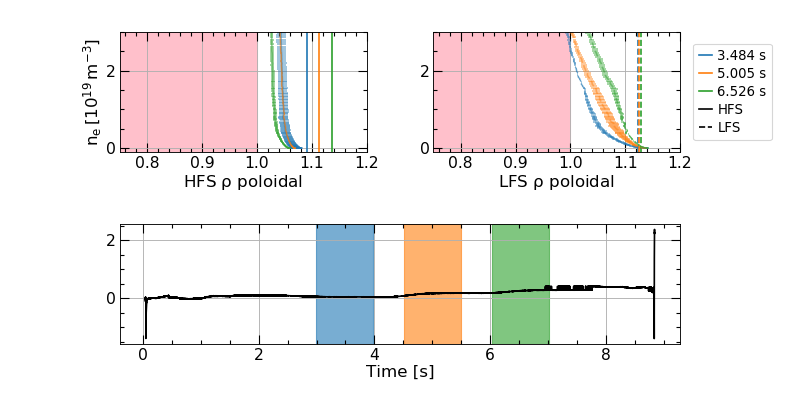

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTYuNTI1Nzk3ODAwMDAzOTE0NSwgZGVzY3JpcHRpb249dSdUaW1lIFtzXScsIG1heD04LjA0MTY0NzgwMDAwMzkxNSwgbWnigKY=


In [85]:
fig2 = plt.figure(figsize=(10, 5))
plt.subplots_adjust(hspace=0.6)

# Supporting plot with colored lines
ax4 = plt.subplot(212)
stamp2 = []
ax4.plot(signal.time, signal.data, color='k')
for a, b in indexes:
#     l = ax4.axvline(time[i], color=next(ax4._get_lines.prop_cycler)['color'])
    color = next(ax4._get_lines.prop_cycler)['color']
    l = ax4.axvspan(time[a], time[b], color=color, alpha=0.6)
    stamp2.append(l)

if show_same:
    ax5 = plt.subplot(211)
    ax6 = ax5
else:
    ax5 = plt.subplot(221)
    
    ax6 = plt.subplot(222, sharey=ax5, sharex=ax5)

rhoh = []
hfs_wall = []
rhol = []
lfs_wall = []
   
legend_lines = []
for i in draw:
    color = next(ax5._get_lines.prop_cycler)['color']
    if show_std:
        l = ax5.errorbar(rhoh_average[i], hfs_signal[i]*1e-19, xerr=[rhoh_lowerbound[i], rhoh_upperbound[i]], 
                         alpha=0.5, color=color, label='%.3lf s (HFS)' % time[i])
    else:
        l, = ax5.plot(rhoh[i], hfs_signal[i]*1e-19, color=color, label='%.3lf s (HFS)' % time[i])
    rhoh.append(l)
    
    legend_lines.append(Line2D([0], [0], color=color, linewidth=1.5, linestyle='-'))
    
    if show_std:
        l = ax6.errorbar(rhol_average[i], hfs_signal[i]*1e-19, xerr=[rhol_lowerbound[i], rhol_upperbound[i]], 
                         alpha=0.5, color=color, linestyle='--', label='%.3lf s (LFS)' % time[i])
    else:
        l, = ax6.plot(rhoh[i], hfs_signal[i]*1e-19, color=color, label='%.3lf s (LFS)' % time[i])
    rhol.append(l)
    
    if show_wall:
        l = ax5.axvline(inner_wall_rho[i], color=color, linestyle='-')
        hfs_wall.append(l)
        l = ax6.axvline(outer_wall_rho[i], color=color, linestyle='--')
        lfs_wall.append(l)
        
solid_line = Line2D([0], [0], color='k', linewidth=1.5, linestyle='-')
dashed_line = Line2D([0], [0], color='k', linewidth=1.5, linestyle='--')
        
legend2 = ax6.legend(handles=legend_lines + [solid_line, dashed_line],
                    labels = ["%.3lf s" % time[i] for i in draw] + ['HFS', 'LFS'],
                    loc='center left', bbox_to_anchor=(1, 0, 1, 1))
    
if show_same:
    #labels & text
    ax5.set_ylabel(r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$')
    ax5.set_xlabel(r'$\rho$ poloidal')
    ax5.axvspan(0.0, 1.0, color='#FFC0CB')
#     hfs_legend2 = lfs_legend2
    
else:
    #labels & text
    ax5.set_ylabel(r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$')
    ax5.set_xlabel(r'HFS $\rho$ poloidal')
    ax6.set_xlabel(r'LFS $\rho$ poloidal')
    ax5.axvspan(0.0, 1.0, color='#FFC0CB')
    ax6.axvspan(0.0, 1.0, color='#FFC0CB')
    
# Default limits for plotting
ax5.set_xlim(0.75, 1.2)
ax5.set_ylim(-0.1, 3)

ax4.set_xlabel('Time [s]')
# ax4.set_ylim(-0.1, 0.5)



def update2(**kwargs):
    slider_time = kwargs.values()
    slider_time.sort()
    for i, ts in enumerate(slider_time):
        time_index = closest(time, ts)
        if show_std:
            update_errorbar(rhoh[i], rhoh_average[time_index], hfs_signal[time_index]*1e-19, 
                            lowxerr=rhoh_lowerbound[time_index], upxerr=rhoh_upperbound[time_index])
            update_errorbar(rhol[i], rhol_average[time_index], lfs_signal[time_index]*1e-19, 
                            lowxerr=rhol_lowerbound[time_index], upxerr=rhol_upperbound[time_index])
        else:
            rhoh[i].set_xdata(hfs_average[time_index])
            rhol[i].set_xdata(lfs_average[time_index])
#         stamp[i].set_xdata(2*[ts])
        stamp2[i].set_xy(
        [[ts-time_window/2000., 0.        ],
         [ts-time_window/2000., 1.        ],
         [ts+time_window/2000., 1.        ],
         [ts+time_window/2000., 0.        ],
         [ts-time_window/2000., 0.        ]]
        )
        if show_wall:
            hfs_wall[i].set_xdata(2*[inner_wall_rho[time_index]])
            lfs_wall[i].set_xdata(2*[outer_wall_rho[time_index]])
        legend2.get_texts()[i].set_text('%.3lf s' % ts)
#         lfs_legend2.get_texts()[2*i+1 if show_same else i].set_text('%.3lf s (LFS)' % ts)
    
    
sliders2 = []
for i in range(number_of_profiles):
    sliders2.append(widgets.FloatSlider(
        value=time[draw[i]],
        min=time[0],
        max=time[-1],
        step=time[1]-time[0],
        description='Time [s]',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.6f',
    ))
    
kwargs = {'p{0}'.format(i):slider for i, slider in enumerate(sliders2)}

widgets.interact(update2, **kwargs);

In [43]:
save_figure(fig2, "%d_average_profiles_rho" % (shot))

Figure saved to /afs/ipp-garching.mpg.de/home/d/danielhfc/phd-logbooks/logbooks/37765/average_rho_directly.png
